<a href="https://colab.research.google.com/github/SampadSikder/DP-Protocols/blob/main/Metrics_Comparison_of_Normal_and_Attacked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize

In [ ]:
import argparse
import math
import matplotlib.pyplot as plt

In [ ]:
import random
from multiprocessing import Pool
import numpy as np
import xxhash
import pandas as pd
from sklearn.preprocessing import LabelEncoder


In [ ]:
domain = 0
epsilon = 0.0
n = 0
g = 0
X = []
Y = []
Y_Nattack = []
sample = []
REAL_DIST = []
ESTIMATE_DIST = []
User_Seed = []
User_Seed_Nattack = []
p = 0.0
q = 0.0
Gain = 0
splits = 0
h_ao = 0
global Gain, ESTIMATE_DIST, Y

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Parameter loading

In [ ]:
global ESTIMATE_DIST, REAL_DIST, n, p, q, epsilon, domain, User_Seed, User_Seed_Nattack, target_set_size, vswhat, g, splits, h_ao

In [ ]:
epsilon = 0.7
splits = 6
h_ao = 1 # for adaptive attack
g = int(round(math.exp(epsilon))) + 1
dataset = 'emoji'
ratio = 0.4
target_set_size = 20

In [ ]:
if dataset == 'zipf':
        #n = 100000
        n = 30000
        domain = 1024
if dataset == 'emoji':
        #n = 218477
        n = 70000
        domain = 1496
if dataset == 'fire':
        #n = 723090
        n = 30000
        domain = 296

In [ ]:
User_Seed = np.zeros(n)
User_Seed_Nattack = np.zeros(n)
REAL_DIST = np.zeros(domain)
#REAL_DIST = Counter()
ESTIMATE_DIST = np.zeros(domain)

In [ ]:
p = math.exp(epsilon) / (math.exp(epsilon) + g - 1)
q = 1.0 / (math.exp(epsilon) + g - 1)

print('n: ', n)
print('ratio: ', ratio)
print('target_set_size: ', target_set_size)
print('e: ', epsilon)
print('split: ', splits)
print('h_ao: ', h_ao)

n:  70000
ratio:  0.4
target_set_size:  20
e:  0.7
split:  6
h_ao:  1


## Load Dataset

In [ ]:
def generate_zipf_dist():
  global REAL_DIST, domain, sample, X
  X = np.load('/content/drive/MyDrive/Purdue Work/Datasets/zipf.npy')
  for i in range(n):
    REAL_DIST[X[i]] += 1



In [ ]:
def generate_emoji_dist():
  global X
  data = np.load('/content/drive/MyDrive/Purdue Work/Datasets/emoji.npy')
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [ ]:
def generate_fire_dist():
  global X
  values = pd.read_csv("/content/drive/MyDrive/Purdue Work/Datasets/fire.csv")["Unit_ID"]
  #print(np.array(values))
  lf = LabelEncoder().fit(values)
  data = lf.transform(values)
  X = np.copy(data)
  for i in range(n):
      REAL_DIST[data[i]] += 1

In [ ]:
if dataset == 'zipf':
    generate_zipf_dist()
if dataset == 'emoji':
    generate_emoji_dist()
if dataset == 'fire':
    generate_fire_dist()

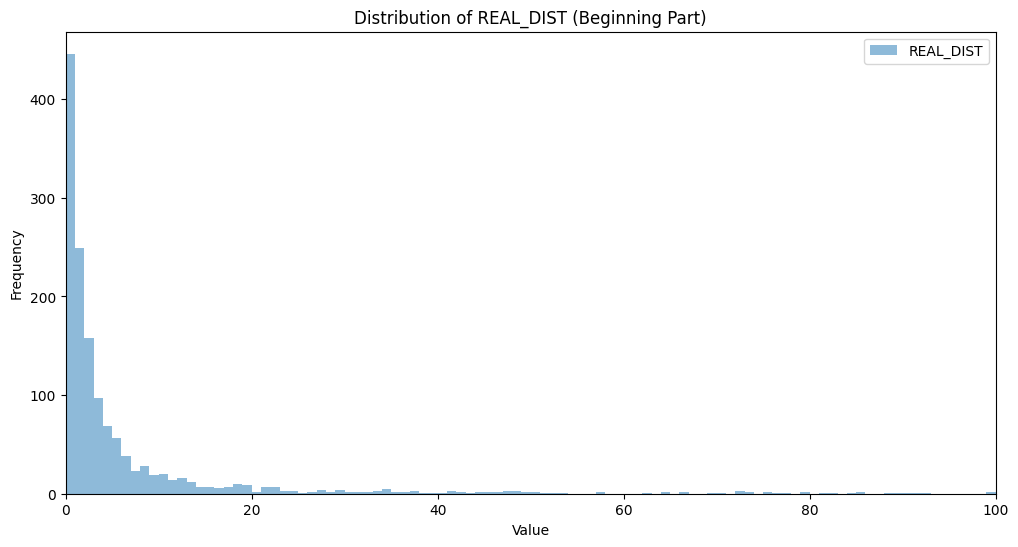

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(REAL_DIST, bins=range(101), alpha=0.5, label='REAL_DIST')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of REAL_DIST (Beginning Part)')
plt.legend()
plt.xlim(0, 100)
plt.show()

## Protocols

In [ ]:
from tqdm import tqdm
import random
# from mlxtend.preprocessing import TransactionEncoder
# from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd
from functools import partial
from multiprocessing import Pool
import math
import scipy.stats as stats
from scipy.stats import binom, chisquare


In [ ]:
# APA Attack
def construct_omega(e, d, perturb_method):
    p_binomial = None
    if perturb_method == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(e) + 1)
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('OLH_User', 'OLH_Server'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / g
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
    elif perturb_method in ('HST_Server', 'HST_User'):
        p_binomial = 1 / 2
        p = q = 1 / 2
        expected_ones = d * p_binomial
    k_values = [i for i in range(d)]
    theoretical_pdf = binom.pmf(k_values, d, p_binomial)
    theoretical_pdf /= theoretical_pdf.sum()
    return theoretical_pdf

In [ ]:
# Example of theoretical pdf from construct_omega
example_pdf = construct_omega(epsilon, domain, 'OLH_User')

print(f'Example of theoretical PDF from construct_omega (first 10 values):')
print(example_pdf[:10])
print(f'Length of the PDF: {len(example_pdf)}')

Example of theoretical PDF from construct_omega (first 10 values):
[2.86931034e-264 2.14733137e-261 8.02971659e-259 2.00041228e-256
 3.73516060e-254 5.57568269e-252 6.93129518e-250 7.38061539e-248
 6.87206466e-246 5.68378460e-244]
Length of the PDF: 1496


In [ ]:
def perturb_ideal(target_set = None, ratio = 0, e = 0):
    global Y, Gain, User_Seed
    Y = np.zeros(n)
    #random.shuffle(X)
    for i in range(n):
        if i < n * (1 - ratio):
            v = X[i]
            # intdigest -> get integer value from xxhash(Output of xxhash is a hash item)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()

            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
        else:
            projection_total = len(target_set)
            max_seed = i
            v = random.choice(target_set)
            x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
            y = x
            p_sample = np.random.random_sample()
            if p_sample > p - q:
                # perturb
                y = np.random.randint(0, g)
            Y[i] = y
            User_Seed[i] = i
    return User_Seed

## OLH

### Attacked OLH

In [ ]:
num_samples = 1000000


In [ ]:
def uniform_sampling_best_vector(target_set, g, d, m, num_samples):
    best_vector = None
    closest_ones_diff = float('inf')
    max_target_count = 0
    best_score = -float('inf')
    current_target = None
    current_diff = None

    for _ in range(num_samples):
        # Generate uniform samples for binary vectors (0 or 1)
        vector = np.random.binomial(1, 1 / g, size=d)

        # Count the number of 1's in the vector
        ones_count = np.sum(vector)
        ones_diff = abs(ones_count - m)  # Difference between current 1's count and target m

        # Count how many target items map to positions with 1's in the vector
        target_count = sum(1 for item in target_set if vector[item % d] == 1)

        # Calculate the score: target_count - ones_diff
        score = target_count - ones_diff

        # Update the best vector if the score is better
        if score > best_score:
            best_score = score
            best_vector = vector
            current_target = target_count
            current_diff = ones_diff

    return best_vector, current_target, current_diff

In [ ]:
def calculate_prob_according_sample_size(num_samples, d, g, h, target_set, splits):

    splits_list = random.sample(list(target_set), splits)
    target_set = splits_list
    user_vectors = []
    p = 1 / g

    mu = d * p
    sigma = np.sqrt(d * p * (1 - p))

    lower_bound = max(0, mu - h)
    upper_bound = min(d, mu + h)

    binom_dist = stats.binom(d, p)
    ratio = (binom_dist.cdf(upper_bound) - binom_dist.cdf(lower_bound - 1))
    ratio = ratio / (2 * h + 1)
    # ratio = 1

    N_effective = num_samples * ratio
    print('N_effective: ', N_effective)

    K_min = 1
    K_max = len(target_set)
    for K in range(K_max, K_min - 1, -1):
        prob = (p) ** K * N_effective
        if prob < 1:
            K_max = K
        else:
            break
    K_min = max(K_max, 1)

    K_values = np.arange(K_min, len(target_set) + 1)
    K_probs = []
    for K in K_values:
        prob = (p) ** K * N_effective
        K_probs.append(prob)
    K_probs = np.array(K_probs)

    K_probs = K_probs / np.sum(K_probs)

    return K_values, K_probs

In [ ]:
def process_attacker(i, n, ratio, target_set, g, domain, splits, h_ao, e, K_values, K_probs):
    # Seed the random number generator uniquely for each process
    k = np.random.choice(K_values, p=K_probs)
    random.seed()
    averge_project_hash = int(domain / g)
    if splits < averge_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = averge_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        #h_ao = 0
        if h_ao == 0:
          num_map_AO = random.randint(num_map - int(h_ao), num_map + int(h_ao))
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        else:
          omega_probs = construct_omega(e, domain, 'OLH_User')
          num_map_AO = np.random.choice(range(domain), p=omega_probs)
        non_target_ones = num_map_AO - k
        # Each attacker finds their optimal hash function
        '''best_vector, target_map, diff  = uniform_sampling_best_vector(
            splits_list, g, domain, num_map_AO, num_samples)'''
        target_indices = np.random.choice(list(splits_list), size=k, replace=False)
        non_target_indices = list(set(range(domain)) - set(splits_list))
        non_target_selected = np.random.choice(non_target_indices, size=non_target_ones, replace=False)
        vector = np.zeros(domain, dtype=int)
        vector[target_indices] = 1
        vector[non_target_selected] = 1
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    #print(f'attacker:{i}, target_map:{k}, diff:{num_map_AO - sum(vector)}, h_ao:{h_ao}, splits:{splits}')
    return index, vector

In [ ]:
def process_user_seeds(i, User_Seed_noattack, Y_Nattack, domain, g):
    print("Processing index" + str(i))
    local_estimate = np.zeros(domain)
    user_seed = User_Seed_noattack[i]
    for v in range(domain):
        if Y_Nattack[i] == (xxhash.xxh3_64(str(v), seed=int(user_seed)).intdigest() % g):
            local_estimate[v] += 1
    # Apply the correction factor
    local_estimate = local_estimate
    return local_estimate

In [ ]:
def find_hash_function(seed_list, target_set, domain_eliminate, g, num_map_AO):
    # log the max projection number
    best_score = -np.inf
    # log the best projection seed
    best_seed = -1
    # log the target mapped
    best_target_mapped = None
    # log the best hash value
    best_hash_value = None
    # log the min gap
    best_gap = None
    for seed in seed_list:
        hash_projection_list = np.zeros(g)
        hash_other_projection_list = np.zeros(g)
        hash_result = None
        for item in target_set:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_projection_list[hash_result] += 1
        for item in domain_eliminate:
            hash_result = xxhash.xxh3_64(str(item), seed=seed).intdigest() % g
            hash_other_projection_list[hash_result] += 1
        score = hash_projection_list - np.abs(num_map_AO - hash_projection_list - hash_other_projection_list)
        current_best_score = np.max(score)
        max_indices = np.where(score == current_best_score)[0]
        current_max_target_mapped = hash_projection_list[max_indices]
        current_untarget_mapped = hash_other_projection_list[max_indices]
        current_hash_value = max_indices
        current_gap = np.abs(num_map_AO - current_max_target_mapped - current_untarget_mapped)
        if current_best_score > best_score:
            best_seed = seed
            best_score = current_best_score
            best_hash_value = current_hash_value
            best_gap = current_gap
            best_target_mapped = current_max_target_mapped
    if best_seed == -1:
        return -1, 0.0, None
    return best_seed, best_gap, best_target_mapped, best_hash_value


In [ ]:
def process_attacker_User(i, n, ratio, target_set, g, domain, splits, e, h_ao):
    average_project_hash = int(domain / g)
    vector = np.zeros(domain, dtype=int)
    if splits < average_project_hash:
        # Split the target set for each user
        splits_list = random.sample(list(target_set), splits)
        # Gap between average mapping
        num_map = average_project_hash
        # Remaining set (unused in this snippet but kept for completeness)
        remaining_set = set(range(domain)) - set(target_set)
        # Adaptive gap between average mapping
        num_map_AO = random.randint(num_map - h_ao, num_map + h_ao)
        # theoretical APA use the omega_list to replace the num_map_AO num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        #num_map_AO = np.random.choice([i for i in range(domain)], construct_omega(e, domain, 'OLH_User'))
        seed_list = random.sample(range(1, 10000000), num_samples)
        best_seed, best_gap, current_max_target_mapped, best_hash_value = find_hash_function(seed_list, splits_list,
                                                                                             remaining_set, g,
                                                                                             num_map_AO)
    else:
        print('splits > averge_project_hash')
        exit(0)
    # Calculate the index in User_Seed to update
    index = int(n * (1 - ratio) + i)
    for v in range(domain):
        hashed_value = xxhash.xxh3_64(str(v), seed=int(best_seed)).intdigest() % g
        if hashed_value == best_hash_value:
            vector[v] = 1
   # print(f'attacker:{i}, target_map:{current_max_target_mapped}, diff:{best_gap}, h_ao:{h_ao}, splits:{splits}')
    return index, vector


In [ ]:

def build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, e, h_ao=0, processor=100):

    K_values, K_probs = calculate_prob_according_sample_size(num_samples, domain, g, h_ao, target_set, splits)

    # Prepare the partial function with fixed arguments for multiprocessing
    process_attacker_partial = partial(
        #process_attacker_User,
        # Simulate 1,000,000 hash samples, fast version
        process_attacker,
        n=n,
        ratio=ratio,
        target_set=target_set,
        g=g,
        domain=domain,
        splits=splits,
        h_ao= 10*h_ao,
        e=e,
        K_values = K_values,
        K_probs = K_probs
    )

    # Calculate the number of attackers
    num_attackers = int(round(n * ratio))

    # Parallel execution of process_attacker using multiprocessing
    with Pool(processes=processor) as pool:
        # Use imap to process in parallel and tqdm for progress bar
        results = list(tqdm(
            pool.imap(process_attacker_partial, range(num_attackers)),
            total=num_attackers,
            desc='Finding optimal seeds'
        ))

    vector_matrix = np.zeros((num_attackers, domain))
    # Update User_Seed with the results from all attackers
    for i, (index, best_vector) in enumerate(results):
        vector_matrix[i, :] = best_vector

    # Create a partial function with fixed arguments for processing user seeds
    process_partial = partial(
        process_user_seeds,
        User_Seed_noattack=User_Seed,
        Y_Nattack=Y,
        domain=domain,
        g=g
    )

    # Process user seeds across multiple processes
    with Pool(processes=processor) as pool:
        estimates = pool.map(process_partial, range(n - num_attackers))
    # input attack's estimate
    '''with Pool(processes=processor) as pool:
        estimates_input = pool.map(process_partial, range(int(n)))'''

    # Combine the results from all processes
    estimates = np.array(estimates)
    # estimates_input = np.array(estimates_input)
    # estimates_input = estimates_input.reshape(int(n), domain)
    estimates = np.vstack((estimates, vector_matrix))
    estimates = estimates.reshape(int(n), domain)
    Results_support = estimates
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = np.sum(Results_support, axis=0)
    # Estimations_input = np.sum(estimates_input, axis=0)
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations = a * Estimations - b
    # Estimations_input = a * Estimations_input - b
    Estimations_input = None
    return Results_support, Results_support_one_list, Estimations, Estimations_input

### Normal OLH

In [ ]:
def perturb_normal_olh(X, g, p, q):

    Y_normal = np.zeros(len(X))
    for i, v in enumerate(X):
        # Generate hash value
        x = (xxhash.xxh3_64(str(v), seed=i).intdigest() % g)
        y = x
        p_sample = np.random.random_sample()

        # Apply perturbation
        if p_sample <= p:

            # perturb
            y = np.random.randint(0, g)
        Y_normal[i] = y
    return Y_normal

In [ ]:
def build_support_list_normal_olh(Y_normal, n, domain, g, p):
    Results_support_normal = np.zeros((n, domain))
    Estimations_normal_raw = np.zeros(domain)

    for i in range(n):
        user_seed = i  # Use the same seed as in perturbation
        for v in range(domain):
            hashed_value = (xxhash.xxh3_64(str(v), seed=user_seed).intdigest() % g)
            if Y_normal[i] == hashed_value:
                Results_support_normal[i, v] += 1
                Estimations_normal_raw[v] += 1

    Results_support_one_list_normal = np.sum(Results_support_normal, axis=1)

    # Apply the OLH correction factor
    a = 1.0 * g / (p * g - 1)
    b = 1.0 * n / (p * g - 1)
    Estimations_normal = a * Estimations_normal_raw - b

    return Results_support_normal, Results_support_one_list_normal, Estimations_normal

## OUE

### Attacked OUE

In [ ]:
def build_support_list_1_OUE(estimates, n, epsilon):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE
    Results_support = np.array(estimates)
    Estimations = np.sum(Results_support, axis=0)
    Results_support_one_list = np.sum(Results_support, axis=1)
    Estimations = [(i - n * q_OUE) / (p - q_OUE) for i in Estimations]
    Estimations_input = None

    return Results_support, Results_support_one_list, Estimations, Estimations_input


In [ ]:
def perturb_oue_process(args):
    start, end, n, domain, q_OUE, ratio, target_set, X, h_ao, splits, average_1_num_list = args
    local_user_data = np.zeros((end - start, domain), dtype=int)
    h_ao *= 10

    for i in tqdm(range(start, end)):
        v = X[i]
        if i < n * (1 - ratio):
            # benign users
            random_flip = np.random.rand(domain) < q_OUE
            local_user_data[i - start, :] = random_flip
            local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
        else:
            # fake users
            if splits < average_1_num_list[i]:
                splits_list = random.sample(list(target_set), splits)
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
            else:
                splits_list = random.sample(list(target_set), average_1_num_list[i])
                local_user_data[i - start, list(splits_list)] = 1
                remaining_set = list(set(range(domain)) - set(splits_list))
                diff = int(average_1_num_list[i] - len(splits_list))
                diff_AO = random.randint(diff - h_ao, diff + h_ao)
                #print(f'attacker:{i}, exp1:{int(0.5 + (domain - 1) * q_OUE)}, h_ao:{h_ao}, splits:{splits}')
                if diff_AO > 0 and len(remaining_set) >= diff:
                    random_numbers = random.sample(remaining_set, diff_AO)
                    local_user_data[i - start, random_numbers] = 1
    return local_user_data

In [ ]:
def perturb_OUE_multi(target_set = None, ratio = 0, h_ao = 0, split = 0, num_processes=1):
    global p, q
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5
    q = q_OUE
    #theoretical_pdf = construct_omega(epsilon, domain, 'OUE')
    #average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n
    # theoretical APA use the below code to replace the average_1_num_list and set h_ao = 0
    omega_probs = construct_omega(epsilon, domain, 'OUE')
    if h_ao == 1:
        average_1_num_list = np.random.choice([i for i in range(domain)], size=n, p=omega_probs)
    else:
        # When h_ao is not 1, ensure average_1_num_list is an array of size n
        average_1_num_list = [int(0.5 + (domain - 1) * q_OUE)] * n

    # Split the task into chunks for each process
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, n, domain, q_OUE, ratio, target_set, X, h_ao, split, average_1_num_list) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    #Estimations = np.sum(user_data, axis=0)
    return user_data

### Normal OUE

In [ ]:
def perturb_normal_oue_process(args):
    start, end, domain, q_OUE, X = args
    local_user_data = np.zeros((end - start, domain), dtype=int)

    for i in tqdm(range(start, end)):
        v = X[i]
        random_flip = np.random.rand(domain) < q_OUE
        local_user_data[i - start, :] = random_flip
        local_user_data[i - start, v] = 1 if np.random.rand() < 0.5 else 0
    return local_user_data

In [ ]:
def perturb_normal_OUE_multi(X, domain, epsilon, num_processes=1):
    q_OUE = 1 / (math.exp(epsilon) + 1)
    p = 0.5

    # Split the task into chunks for each process
    ranges = [(i * n // num_processes, (i + 1) * n // num_processes, domain, q_OUE, X) for i in range(num_processes)]
    with Pool(num_processes) as pool:
        results = pool.map(perturb_normal_oue_process, ranges)
    # Combine the results from each process
    user_data = np.vstack(results)
    return user_data

## Construction of User 1s and Domain 1s

### Normal 1s

In [ ]:
# Define the protocol (either 'OUE' or 'OLH')
protocol = 'OUE' # Change to 'OUE' to run OUE protocol

if protocol == 'OLH':
    print("Running OLH protocol...")
    # Normal OLH
    Y_normal = perturb_normal_olh(X, g, p, q)
    no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
    no_attack_ESTIMATE_Input = None


elif protocol == 'OUE':
    print("Running OUE protocol...")
    # Normal OUE
    Y_normal = perturb_normal_OUE_multi(X, domain, epsilon, num_processes=2)
    no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST, _ = build_support_list_1_OUE(Y_normal, n, epsilon)

else:
    print("Invalid protocol specified. Please choose 'OLH' or 'OUE'.")

Running OUE protocol...


100%|██████████| 35000/35000 [00:06<00:00, 5809.92it/s] 


In [ ]:
#Y_normal_OUE = perturb_normal_OUE_multi(X, domain, epsilon, num_processes=2)

In [ ]:
#no_attack_support_list_OUE, no_attack_one_list_OUE, no_attack_ESTIMATE_DIST_OUE, _ = build_support_list_1_OUE(Y_normal_OUE, n, epsilon)

In [ ]:
#Y_normal = perturb_normal_olh(X, g, p, q)
#no_attack_support_list, no_attack_one_list, no_attack_ESTIMATE_DIST = build_support_list_normal_olh(Y_normal, n, domain, g, p)
#no_attack_ESTIMATE_Input = None

### Attacked List of 1s

In [ ]:
target_set = random.sample(range(0, domain), target_set_size)


In [ ]:
f_T = sum(REAL_DIST[element] for element in target_set) / sum(REAL_DIST)

Gain = (Gain - n * ratio * (f_T * (p - 1/g) + target_set_size * 1/g)) / (n * (p - 1/g))
print('Gain: ', Gain)

Gain:  -15.837732077899275


In [ ]:

User_Seed = perturb_ideal(target_set, ratio, epsilon)

In [ ]:
# one_list is per user support, EST_DIST is per domain support and support list is per user 1s list
if protocol == "OLH":
  support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OLH(domain, Y, n, User_Seed, ratio, g, target_set, p, splits, h_ao, epsilon, processor=2)
elif protocol == "OUE":
   ESTIMATE_DIST_Matrix = perturb_OUE_multi(target_set, ratio, h_ao, splits)
   perturb_method = 'OUE'
   support_list, one_list, ESTIMATE_DIST_Nattack, ESTIMATE_Input = build_support_list_1_OUE(
        ESTIMATE_DIST_Matrix, n, epsilon)

100%|██████████| 70000/70000 [00:08<00:00, 8527.86it/s]


Comparison of one_list (Attacked) and no_attack_one_list (Non-Attack):
  Mean of one_list: 496.52
  Standard Deviation of one_list: 18.57
  Mean of no_attack_one_list: 496.56
  Standard Deviation of no_attack_one_list: 18.08


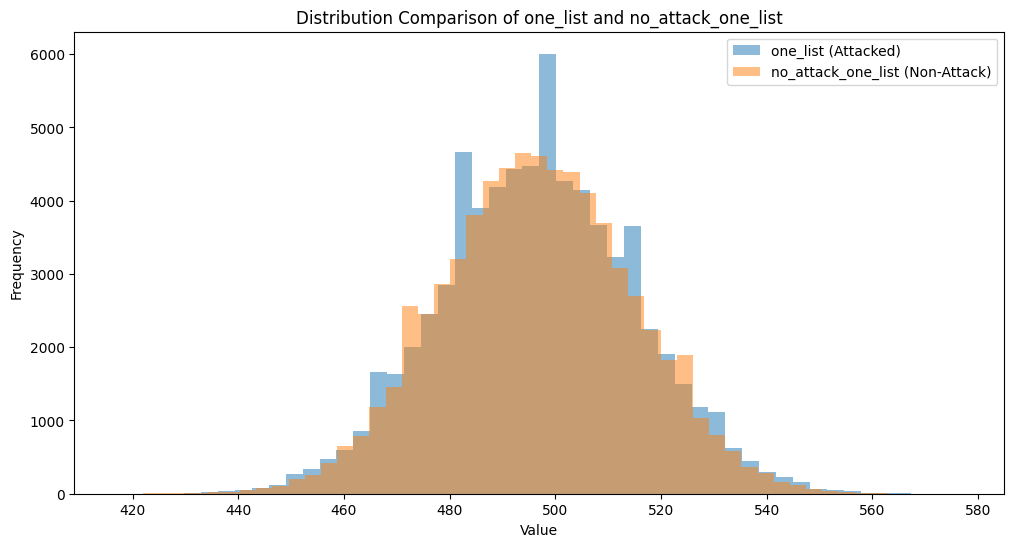

In [ ]:
# Compare statistical measures
mean_one_list = np.mean(one_list)
std_one_list = np.std(one_list)
mean_no_attack_one_list = np.mean(no_attack_one_list)
std_no_attack_one_list = np.std(no_attack_one_list)

print(f'Comparison of one_list (Attacked) and no_attack_one_list (Non-Attack):')
print(f'  Mean of one_list: {mean_one_list:.2f}')
print(f'  Standard Deviation of one_list: {std_one_list:.2f}')
print(f'  Mean of no_attack_one_list: {mean_no_attack_one_list:.2f}')
print(f'  Standard Deviation of no_attack_one_list: {std_no_attack_one_list:.2f}')

# Visualize distributions
plt.figure(figsize=(12, 6))
plt.hist(one_list, bins=50, alpha=0.5, label='one_list (Attacked)')
plt.hist(no_attack_one_list, bins=50, alpha=0.5, label='no_attack_one_list (Non-Attack)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Comparison of one_list and no_attack_one_list')
plt.legend()
plt.show()

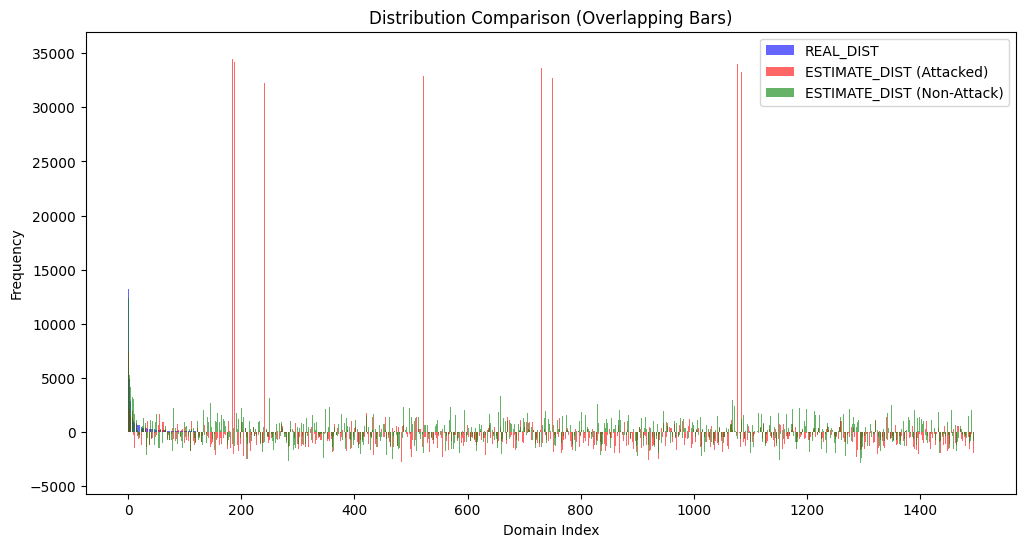

In [ ]:
plt.figure(figsize=(12, 6))
x = range(len(REAL_DIST))
plt.bar(x, REAL_DIST, alpha=0.6, label='REAL_DIST', color='blue')
plt.bar(x, ESTIMATE_DIST_Nattack, alpha=0.6, label='ESTIMATE_DIST (Attacked)', color='red')
plt.bar(x, no_attack_ESTIMATE_DIST, alpha=0.6, label='ESTIMATE_DIST (Non-Attack)', color='green')
plt.xlabel('Domain Index')
plt.ylabel('Frequency')
plt.title('Distribution Comparison (Overlapping Bars)')
plt.legend()
plt.show()

# Statistical Differences

## Comparison between Theoretical and Attack/Non-attack


In [ ]:
from scipy.spatial.distance import jensenshannon
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.metrics import mean_squared_error
e = epsilon
d = domain

In [ ]:
def calculate_distribution_comparisons(real_dist, attack_dist, normal_dist, theoretical_dist=None):
    """
    Calculate various statistical measures to quantify differences between
    real, attacked, normal, and theoretical distributions
    """

    # Ensure arrays are numpy arrays
    real_dist = np.array(real_dist)
    attack_dist = np.array(attack_dist)
    normal_dist = np.array(normal_dist)
    if theoretical_dist is not None:
        theoretical_dist = np.array(theoretical_dist)

    comparisons = {}

    # Helper function to safely normalize distributions
    def normalize_distribution(dist):
        dist_pos = np.maximum(dist, 0)  # Ensure non-negativity
        if np.sum(dist_pos) > 0:
            dist_norm = dist_pos / np.sum(dist_pos)
        else:
            dist_norm = np.ones_like(dist_pos) / len(dist_pos)

        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        dist_norm = dist_norm + epsilon
        dist_norm = dist_norm / np.sum(dist_norm)
        return dist_norm

    # Helper function to create samples from distribution for KS test
    def dist_to_samples(dist, max_samples=10000):
        dist_pos = np.maximum(dist, 0).astype(int)
        if np.sum(dist_pos) == 0:
            return np.array([])

        # Limit samples to avoid memory issues
        total_samples = min(np.sum(dist_pos), max_samples)
        if total_samples < np.sum(dist_pos):
            # Proportionally sample
            dist_pos = (dist_pos * total_samples / np.sum(dist_pos)).astype(int)

        samples = np.repeat(range(len(dist_pos)), dist_pos)
        return samples

    # Normalize all distributions
    real_prob = normalize_distribution(real_dist)
    attack_prob = normalize_distribution(attack_dist)
    normal_prob = normalize_distribution(normal_dist)

    if theoretical_dist is not None:
        theoretical_prob = normalize_distribution(theoretical_dist)

    # ===== REAL vs ATTACK COMPARISONS =====

    # Jensen-Shannon Divergence
    comparisons['real_vs_attack_js'] = jensenshannon(real_prob, attack_prob)

    # KL Divergence
    comparisons['real_vs_attack_kl'] = stats.entropy(real_prob, attack_prob)

    # Wasserstein Distance
    comparisons['real_vs_attack_wasserstein'] = wasserstein_distance(
        range(len(real_dist)), range(len(attack_dist)), real_prob, attack_prob)

    # Total Variation Distance
    comparisons['real_vs_attack_tv'] = 0.5 * np.sum(np.abs(real_prob - attack_prob))

    # Chi-square test
    if len(real_dist) == len(attack_dist):
        observed = np.maximum(attack_dist, 0)
        expected = np.maximum(real_dist, 1e-10)  # Avoid division by zero
        comparisons['real_vs_attack_chi2'] = np.sum((observed - expected)**2 / expected)

        # MSE
        comparisons['real_vs_attack_mse'] = mean_squared_error(real_dist, attack_dist)
    else:
        comparisons['real_vs_attack_chi2'] = np.nan
        comparisons['real_vs_attack_mse'] = np.nan

    # KS test
    real_samples = dist_to_samples(real_dist)
    attack_samples = dist_to_samples(attack_dist)
    if len(real_samples) > 0 and len(attack_samples) > 0:
        ks_stat, ks_pvalue = ks_2samp(real_samples, attack_samples)
        comparisons['real_vs_attack_ks_stat'] = ks_stat
        comparisons['real_vs_attack_ks_pvalue'] = ks_pvalue
    else:
        comparisons['real_vs_attack_ks_stat'] = np.nan
        comparisons['real_vs_attack_ks_pvalue'] = np.nan

    # ===== REAL vs NORMAL COMPARISONS =====

    comparisons['real_vs_normal_js'] = jensenshannon(real_prob, normal_prob)
    comparisons['real_vs_normal_kl'] = stats.entropy(real_prob, normal_prob)
    comparisons['real_vs_normal_wasserstein'] = wasserstein_distance(
        range(len(real_dist)), range(len(normal_dist)), real_prob, normal_prob)
    comparisons['real_vs_normal_tv'] = 0.5 * np.sum(np.abs(real_prob - normal_prob))

    if len(real_dist) == len(normal_dist):
        observed = np.maximum(normal_dist, 0)
        expected = np.maximum(real_dist, 1e-10)
        comparisons['real_vs_normal_chi2'] = np.sum((observed - expected)**2 / expected)
        comparisons['real_vs_normal_mse'] = mean_squared_error(real_dist, normal_dist)
    else:
        comparisons['real_vs_normal_chi2'] = np.nan
        comparisons['real_vs_normal_mse'] = np.nan

    normal_samples = dist_to_samples(normal_dist)
    if len(real_samples) > 0 and len(normal_samples) > 0:
        ks_stat, ks_pvalue = ks_2samp(real_samples, normal_samples)
        comparisons['real_vs_normal_ks_stat'] = ks_stat
        comparisons['real_vs_normal_ks_pvalue'] = ks_pvalue
    else:
        comparisons['real_vs_normal_ks_stat'] = np.nan
        comparisons['real_vs_normal_ks_pvalue'] = np.nan

    # ===== ATTACK vs NORMAL COMPARISONS =====

    comparisons['attack_vs_normal_js'] = jensenshannon(attack_prob, normal_prob)
    comparisons['attack_vs_normal_kl'] = stats.entropy(attack_prob, normal_prob)
    comparisons['attack_vs_normal_wasserstein'] = wasserstein_distance(
        range(len(attack_dist)), range(len(normal_dist)), attack_prob, normal_prob)
    comparisons['attack_vs_normal_tv'] = 0.5 * np.sum(np.abs(attack_prob - normal_prob))

    if len(attack_dist) == len(normal_dist):
        observed = np.maximum(attack_dist, 0)
        expected = np.maximum(normal_dist, 1e-10)
        comparisons['attack_vs_normal_chi2'] = np.sum((observed - expected)**2 / expected)
        comparisons['attack_vs_normal_mse'] = mean_squared_error(attack_dist, normal_dist)
    else:
        comparisons['attack_vs_normal_chi2'] = np.nan
        comparisons['attack_vs_normal_mse'] = np.nan

    if len(attack_samples) > 0 and len(normal_samples) > 0:
        ks_stat, ks_pvalue = ks_2samp(attack_samples, normal_samples)
        comparisons['attack_vs_normal_ks_stat'] = ks_stat
        comparisons['attack_vs_normal_ks_pvalue'] = ks_pvalue
    else:
        comparisons['attack_vs_normal_ks_stat'] = np.nan
        comparisons['attack_vs_normal_ks_pvalue'] = np.nan

    # ===== THEORETICAL COMPARISONS (if provided) =====

    if theoretical_dist is not None:
        theoretical_samples = dist_to_samples(theoretical_dist)

        # Real vs Theoretical
        comparisons['real_vs_theoretical_js'] = jensenshannon(real_prob, theoretical_prob)
        comparisons['real_vs_theoretical_kl'] = stats.entropy(real_prob, theoretical_prob)
        comparisons['real_vs_theoretical_wasserstein'] = wasserstein_distance(
            range(len(real_dist)), range(len(theoretical_dist)), real_prob, theoretical_prob)
        comparisons['real_vs_theoretical_tv'] = 0.5 * np.sum(np.abs(real_prob - theoretical_prob))

        if len(real_dist) == len(theoretical_dist):
            observed = np.maximum(real_dist, 0)
            expected = np.maximum(theoretical_dist, 1e-10)
            comparisons['real_vs_theoretical_chi2'] = np.sum((observed - expected)**2 / expected)
            comparisons['real_vs_theoretical_mse'] = mean_squared_error(real_dist, theoretical_dist)
        else:
            comparisons['real_vs_theoretical_chi2'] = np.nan
            comparisons['real_vs_theoretical_mse'] = np.nan

        if len(real_samples) > 0 and len(theoretical_samples) > 0:
            ks_stat, ks_pvalue = ks_2samp(real_samples, theoretical_samples)
            comparisons['real_vs_theoretical_ks_stat'] = ks_stat
            comparisons['real_vs_theoretical_ks_pvalue'] = ks_pvalue
        else:
            comparisons['real_vs_theoretical_ks_stat'] = np.nan
            comparisons['real_vs_theoretical_ks_pvalue'] = np.nan

        # Attack vs Theoretical
        comparisons['attack_vs_theoretical_js'] = jensenshannon(attack_prob, theoretical_prob)
        comparisons['attack_vs_theoretical_kl'] = stats.entropy(attack_prob, theoretical_prob)
        comparisons['attack_vs_theoretical_wasserstein'] = wasserstein_distance(
            range(len(attack_dist)), range(len(theoretical_dist)), attack_prob, theoretical_prob)
        comparisons['attack_vs_theoretical_tv'] = 0.5 * np.sum(np.abs(attack_prob - theoretical_prob))

        if len(attack_dist) == len(theoretical_dist):
            observed = np.maximum(attack_dist, 0)
            expected = np.maximum(theoretical_dist, 1e-10)
            comparisons['attack_vs_theoretical_chi2'] = np.sum((observed - expected)**2 / expected)
            comparisons['attack_vs_theoretical_mse'] = mean_squared_error(attack_dist, theoretical_dist)
        else:
            comparisons['attack_vs_theoretical_chi2'] = np.nan
            comparisons['attack_vs_theoretical_mse'] = np.nan

        if len(attack_samples) > 0 and len(theoretical_samples) > 0:
            ks_stat, ks_pvalue = ks_2samp(attack_samples, theoretical_samples)
            comparisons['attack_vs_theoretical_ks_stat'] = ks_stat
            comparisons['attack_vs_theoretical_ks_pvalue'] = ks_pvalue
        else:
            comparisons['attack_vs_theoretical_ks_stat'] = np.nan
            comparisons['attack_vs_theoretical_ks_pvalue'] = np.nan

        # Normal vs Theoretical
        comparisons['normal_vs_theoretical_js'] = jensenshannon(normal_prob, theoretical_prob)
        comparisons['normal_vs_theoretical_kl'] = stats.entropy(normal_prob, theoretical_prob)
        comparisons['normal_vs_theoretical_wasserstein'] = wasserstein_distance(
            range(len(normal_dist)), range(len(theoretical_dist)), normal_prob, theoretical_prob)
        comparisons['normal_vs_theoretical_tv'] = 0.5 * np.sum(np.abs(normal_prob - theoretical_prob))

        if len(normal_dist) == len(theoretical_dist):
            observed = np.maximum(normal_dist, 0)
            expected = np.maximum(theoretical_dist, 1e-10)
            comparisons['normal_vs_theoretical_chi2'] = np.sum((observed - expected)**2 / expected)
            comparisons['normal_vs_theoretical_mse'] = mean_squared_error(normal_dist, theoretical_dist)
        else:
            comparisons['normal_vs_theoretical_chi2'] = np.nan
            comparisons['normal_vs_theoretical_mse'] = np.nan

        if len(normal_samples) > 0 and len(theoretical_samples) > 0:
            ks_stat, ks_pvalue = ks_2samp(normal_samples, theoretical_samples)
            comparisons['normal_vs_theoretical_ks_stat'] = ks_stat
            comparisons['normal_vs_theoretical_ks_pvalue'] = ks_pvalue
        else:
            comparisons['normal_vs_theoretical_ks_stat'] = np.nan
            comparisons['normal_vs_theoretical_ks_pvalue'] = np.nan

    # ===== DISTRIBUTIONAL MOMENTS =====

    # Calculate moments for each distribution (treating as probability distributions)
    def calculate_moments(dist_prob, domain=None):
        if domain is None:
            domain = range(len(dist_prob))

        mean = np.sum(domain * dist_prob)
        variance = np.sum(((domain - mean) ** 2) * dist_prob)
        std = np.sqrt(variance)

        # Skewness and kurtosis
        if std > 0:
            skewness = np.sum(((domain - mean) ** 3) * dist_prob) / (std ** 3)
            kurtosis = np.sum(((domain - mean) ** 4) * dist_prob) / (std ** 4) - 3
        else:
            skewness = 0
            kurtosis = 0

        return {'mean': mean, 'std': std, 'variance': variance, 'skewness': skewness, 'kurtosis': kurtosis}

    domain = range(max(len(real_dist), len(attack_dist), len(normal_dist)))

    real_moments = calculate_moments(real_prob, domain[:len(real_prob)])
    attack_moments = calculate_moments(attack_prob, domain[:len(attack_prob)])
    normal_moments = calculate_moments(normal_prob, domain[:len(normal_prob)])

    # Moment differences
    comparisons['real_attack_mean_diff'] = real_moments['mean'] - attack_moments['mean']
    comparisons['real_attack_std_diff'] = real_moments['std'] - attack_moments['std']
    comparisons['real_attack_skew_diff'] = real_moments['skewness'] - attack_moments['skewness']
    comparisons['real_attack_kurt_diff'] = real_moments['kurtosis'] - attack_moments['kurtosis']

    comparisons['real_normal_mean_diff'] = real_moments['mean'] - normal_moments['mean']
    comparisons['real_normal_std_diff'] = real_moments['std'] - normal_moments['std']
    comparisons['real_normal_skew_diff'] = real_moments['skewness'] - normal_moments['skewness']
    comparisons['real_normal_kurt_diff'] = real_moments['kurtosis'] - normal_moments['kurtosis']

    comparisons['attack_normal_mean_diff'] = attack_moments['mean'] - normal_moments['mean']
    comparisons['attack_normal_std_diff'] = attack_moments['std'] - normal_moments['std']
    comparisons['attack_normal_skew_diff'] = attack_moments['skewness'] - normal_moments['skewness']
    comparisons['attack_normal_kurt_diff'] = attack_moments['kurtosis'] - normal_moments['kurtosis']

    if theoretical_dist is not None:
        theoretical_moments = calculate_moments(theoretical_prob, domain[:len(theoretical_prob)])

        comparisons['real_theoretical_mean_diff'] = real_moments['mean'] - theoretical_moments['mean']
        comparisons['real_theoretical_std_diff'] = real_moments['std'] - theoretical_moments['std']
        comparisons['real_theoretical_skew_diff'] = real_moments['skewness'] - theoretical_moments['skewness']
        comparisons['real_theoretical_kurt_diff'] = real_moments['kurtosis'] - theoretical_moments['kurtosis']

        comparisons['attack_theoretical_mean_diff'] = attack_moments['mean'] - theoretical_moments['mean']
        comparisons['attack_theoretical_std_diff'] = attack_moments['std'] - theoretical_moments['std']
        comparisons['attack_theoretical_skew_diff'] = attack_moments['skewness'] - theoretical_moments['skewness']
        comparisons['attack_theoretical_kurt_diff'] = attack_moments['kurtosis'] - theoretical_moments['kurtosis']

        comparisons['normal_theoretical_mean_diff'] = normal_moments['mean'] - theoretical_moments['mean']
        comparisons['normal_theoretical_std_diff'] = normal_moments['std'] - theoretical_moments['std']
        comparisons['normal_theoretical_skew_diff'] = normal_moments['skewness'] - theoretical_moments['skewness']
        comparisons['normal_theoretical_kurt_diff'] = normal_moments['kurtosis'] - theoretical_moments['kurtosis']

    return comparisons

In [ ]:
def print_distribution_analysis(comparisons):
    """
    Print a comprehensive analysis of distribution comparisons
    """
    print("=" * 80)
    print("DISTRIBUTION COMPARISON ANALYSIS")
    print("=" * 80)

    print("\n🔥 REAL vs ATTACK DISTRIBUTION:")
    print(f"  Jensen-Shannon Divergence: {comparisons['real_vs_attack_js']:.6f}")
    print(f"  Wasserstein Distance: {comparisons['real_vs_attack_wasserstein']:.6f}")
    print(f"  Total Variation Distance: {comparisons['real_vs_attack_tv']:.6f}")
    print(f"  Chi-square Statistic: {comparisons['real_vs_attack_chi2']:.6f}")
    print(f"  KS Test p-value: {comparisons['real_vs_attack_ks_pvalue']:.6f}")

    print("\n🛡️ REAL vs NORMAL DISTRIBUTION:")
    print(f"  Jensen-Shannon Divergence: {comparisons['real_vs_normal_js']:.6f}")
    print(f"  Wasserstein Distance: {comparisons['real_vs_normal_wasserstein']:.6f}")
    print(f"  Total Variation Distance: {comparisons['real_vs_normal_tv']:.6f}")
    print(f"  Chi-square Statistic: {comparisons['real_vs_normal_chi2']:.6f}")
    print(f"  KS Test p-value: {comparisons['real_vs_normal_ks_pvalue']:.6f}")

    print("\n⚔️ ATTACK vs NORMAL DISTRIBUTION:")
    print(f"  Jensen-Shannon Divergence: {comparisons['attack_vs_normal_js']:.6f}")
    print(f"  Wasserstein Distance: {comparisons['attack_vs_normal_wasserstein']:.6f}")
    print(f"  Total Variation Distance: {comparisons['attack_vs_normal_tv']:.6f}")
    print(f"  Chi-square Statistic: {comparisons['attack_vs_normal_chi2']:.6f}")
    print(f"  KS Test p-value: {comparisons['attack_vs_normal_ks_pvalue']:.6f}")

    if 'real_vs_theoretical_js' in comparisons:
        print("\n📊 THEORETICAL COMPARISONS:")
        print(f"  Real vs Theoretical JS: {comparisons['real_vs_theoretical_js']:.6f}")
        print(f"  Attack vs Theoretical JS: {comparisons['attack_vs_theoretical_js']:.6f}")
        print(f"  Normal vs Theoretical JS: {comparisons['normal_vs_theoretical_js']:.6f}")

    print("\n📈 MOMENT DIFFERENCES:")
    print(f"  Attack-Normal Mean Diff: {comparisons['attack_normal_mean_diff']:.6f}")
    print(f"  Attack-Normal Std Diff: {comparisons['attack_normal_std_diff']:.6f}")
    print(f"  Attack-Normal Skew Diff: {comparisons['attack_normal_skew_diff']:.6f}")


In [ ]:
if protocol == 'OUE':
        p = 1 / 2
        q = 1 / (math.exp(e) + 1)
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
elif protocol in ('OLH_User', 'OLH_Server', 'OLH'):
        g = int(round(math.exp(e))) + 1
        p = math.exp(e) / (math.exp(e) + g - 1)
        q = 1 / g
        expected_ones = p + (d - 1) * q
        p_binomial = (1 / d) * (p + (d - 1) * q)
elif protocol in ('HST_Server', 'HST_User'):
        p_binomial = 1 / 2
        p = q = 1 / 2
        expected_ones = d * p_binomial
# Adjust k_values to match the length of REAL_DIST
k_values = range(domain)
theoretical_pdf = binom.pmf(k_values, domain, p_binomial)
theoretical_freq = theoretical_pdf * n

In [ ]:
comparisons = calculate_distribution_comparisons(
    REAL_DIST,
    ESTIMATE_DIST_Nattack,
    no_attack_ESTIMATE_DIST,
    theoretical_freq
)


In [ ]:
print_distribution_analysis(comparisons)


DISTRIBUTION COMPARISON ANALYSIS

🔥 REAL vs ATTACK DISTRIBUTION:
  Jensen-Shannon Divergence: 0.768730
  Wasserstein Distance: 713.067810
  Total Variation Distance: 0.932331
  Chi-square Statistic: 66203541343813189632.000000
  KS Test p-value: 0.000000

🛡️ REAL vs NORMAL DISTRIBUTION:
  Jensen-Shannon Divergence: 0.675066
  Wasserstein Distance: 660.859777
  Total Variation Distance: 0.822697
  Chi-square Statistic: 2677189794475851776.000000
  KS Test p-value: 0.000000

⚔️ ATTACK vs NORMAL DISTRIBUTION:
  Jensen-Shannon Divergence: 0.746172
  Wasserstein Distance: 135.294854
  Total Variation Distance: 0.881258
  Chi-square Statistic: 113102720816612065280.000000
  KS Test p-value: 0.000000

📊 THEORETICAL COMPARISONS:
  Real vs Theoretical JS: 0.821826
  Attack vs Theoretical JS: 0.808021
  Normal vs Theoretical JS: 0.778972

📈 MOMENT DIFFERENCES:
  Attack-Normal Mean Diff: 52.208033
  Attack-Normal Std Diff: -92.121667
  Attack-Normal Skew Diff: -0.244045


## Comparison Between Attack and No attack

In [ ]:
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

In [ ]:
def calculate_distribution_differences(attack_dist, normal_dist, attack_one_list, normal_one_list):
    """
    Calculate various statistical measures to quantify differences between
    attacked and normal distributions/one_lists
    """

    # Ensure arrays are numpy arrays
    attack_dist = np.array(attack_dist)
    normal_dist = np.array(normal_dist)
    attack_one_list = np.array(attack_one_list)
    normal_one_list = np.array(normal_one_list)

    differences = {}

    # 1. Jensen-Shannon Divergence (symmetric KL divergence)
    # Ensure non-negativity and normalize for probability distributions
    attack_prob = np.maximum(attack_dist, 0)
    normal_prob = np.maximum(normal_dist, 0)

    attack_prob = attack_prob / np.sum(attack_prob) if np.sum(attack_prob) > 0 else attack_prob
    normal_prob = normal_prob / np.sum(normal_prob) if np.sum(normal_prob) > 0 else normal_prob

    epsilon = 1e-10
    attack_prob = attack_prob + epsilon
    normal_prob = normal_prob + epsilon
    attack_prob = attack_prob / np.sum(attack_prob)
    normal_prob = normal_prob / np.sum(normal_prob)

    js_divergence = jensenshannon(attack_prob, normal_prob)
    differences['jensen_shannon_divergence'] = js_divergence

    # 2. Kullback-Leibler Divergence (directional)
    kl_divergence = stats.entropy(attack_prob, normal_prob)
    differences['kl_divergence'] = kl_divergence

    # 3. Wasserstein Distance (Earth Mover's Distance)
    # Use the non-negative probabilities for Wasserstein distance
    wasserstein_dist = wasserstein_distance(range(len(attack_dist)), range(len(normal_dist)),
                                          attack_prob, normal_prob)
    differences['wasserstein_distance'] = wasserstein_dist

    # 4. Kolmogorov-Smirnov Test
    # First convert distributions to samples
    # Need to handle potential non-integer counts due to estimation.
    # Rounding to nearest integer or sampling based on probability could be options.
    # For simplicity here, we'll skip KS test on distributions with negative estimates.
    # A more robust approach would involve a different test or distribution transformation.
    attack_samples = np.repeat(range(len(attack_dist)), np.maximum(attack_dist, 0).astype(int))
    normal_samples = np.repeat(range(len(normal_dist)), np.maximum(normal_dist, 0).astype(int))


    if len(attack_samples) > 0 and len(normal_samples) > 0:
        # KS test requires non-negative counts. Using rounded non-negative counts.
        ks_stat, ks_pvalue = ks_2samp(attack_samples, normal_samples)
        differences['ks_statistic'] = ks_stat
        differences['ks_pvalue'] = ks_pvalue
    else:
        differences['ks_statistic'] = np.nan
        differences['ks_pvalue'] = np.nan


    # 5. Chi-square test
    if len(attack_dist) == len(normal_dist):
        # Combine distributions for chi-square test
        # Chi-square test requires non-negative observed and expected frequencies
        observed = np.maximum(attack_dist, 0)
        expected = np.maximum(normal_dist, 0)
        # Avoid division by zero
        expected = np.where(expected == 0, 1e-10, expected) # Use a small epsilon for expected=0
        chi2_stat = np.sum((observed - expected)**2 / expected)
        differences['chi_square_statistic'] = chi2_stat
    else:
        differences['chi_square_statistic'] = np.nan

    # 6. Mean Squared Error between distributions
    if len(attack_dist) == len(normal_dist):
        mse_dist = mean_squared_error(normal_dist, attack_dist) # MSE can handle negative values
        differences['distribution_mse'] = mse_dist
    else:
        differences['distribution_mse'] = np.nan

    # 7. Total Variation Distance
    tv_distance = 0.5 * np.sum(np.abs(attack_prob - normal_prob))
    differences['total_variation_distance'] = tv_distance


    # 8. Statistical moments comparison
    differences['mean_difference'] = np.mean(attack_one_list) - np.mean(normal_one_list)
    differences['std_difference'] = np.std(attack_one_list) - np.std(normal_one_list)
    differences['skewness_difference'] = stats.skew(attack_one_list) - stats.skew(normal_one_list)
    differences['kurtosis_difference'] = stats.kurtosis(attack_one_list) - stats.kurtosis(normal_one_list)

    # 9. Two-sample t-test
    t_stat, t_pvalue = stats.ttest_ind(attack_one_list, normal_one_list)
    differences['t_test_statistic'] = t_stat
    differences['t_test_pvalue'] = t_pvalue

    # 10. Mann-Whitney U test (non-parametric)
    u_stat, u_pvalue = stats.mannwhitneyu(attack_one_list, normal_one_list, alternative='two-sided')
    differences['mannwhitney_statistic'] = u_stat
    differences['mannwhitney_pvalue'] = u_pvalue

    # 11. Kolmogorov-Smirnov test for one_lists
    ks_one_stat, ks_one_pvalue = ks_2samp(attack_one_list, normal_one_list)
    differences['ks_one_list_statistic'] = ks_one_stat
    differences['ks_one_list_pvalue'] = ks_one_pvalue

    # 15. Range and IQR differences
    attack_range = np.ptp(attack_one_list)  # peak-to-peak (range)
    normal_range = np.ptp(normal_one_list)
    differences['range_difference'] = attack_range - normal_range

    attack_iqr = np.percentile(attack_one_list, 75) - np.percentile(attack_one_list, 25)
    normal_iqr = np.percentile(normal_one_list, 75) - np.percentile(normal_one_list, 25)
    differences['iqr_difference'] = attack_iqr - normal_iqr


    return differences

In [ ]:
def create_feature_vector(differences):
    """
    Create a feature vector for machine learning from the differences dictionary
    """
    features = []
    feature_names = []

    for key, value in differences.items():
        if not np.isnan(value) and not np.isinf(value):
            features.append(value)
            feature_names.append(key)

    return np.array(features), feature_names

In [ ]:
def plot_comparison_analysis(attack_dist, normal_dist, attack_one_list, normal_one_list, differences):
    """
    Create comprehensive visualization of the differences
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Distribution comparison
    axes[0, 0].bar(range(len(normal_dist)), normal_dist, alpha=0.6, label='Normal', color='blue')
    axes[0, 0].bar(range(len(attack_dist)), attack_dist, alpha=0.6, label='Attack', color='red')
    axes[0, 0].set_title('Distribution Comparison')
    axes[0, 0].set_xlabel('Domain Values')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()

    # Plot 2: One_list histograms
    axes[0, 1].hist(normal_one_list, bins=50, alpha=0.6, label='Normal', color='blue', density=True)
    axes[0, 1].hist(attack_one_list, bins=50, alpha=0.6, label='Attack', color='red', density=True)
    axes[0, 1].set_title('One List Distribution')
    axes[0, 1].set_xlabel('Values')
    axes[0, 1].set_ylabel('Density')
    axes[0, 1].legend()

    # Plot 3: Box plots
    axes[0, 2].boxplot([normal_one_list, attack_one_list], labels=['Normal', 'Attack'])
    axes[0, 2].set_title('Box Plot Comparison')
    axes[0, 2].set_ylabel('Values')

    # Plot 4: Q-Q plot
    from scipy.stats import probplot
    probplot(attack_one_list, dist=stats.norm, plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot: Attack vs Normal Distribution')

    # Plot 5: Statistical measures bar chart
    key_measures = ['jensen_shannon_divergence', 'wasserstein_distance', 'mean_difference',
                   'std_difference', 'ks_one_list_statistic']
    key_values = [differences.get(k, 0) for k in key_measures]

    axes[1, 1].bar(range(len(key_measures)), key_values, color=['red', 'orange', 'yellow', 'green', 'blue'])
    axes[1, 1].set_xticks(range(len(key_measures)))
    axes[1, 1].set_xticklabels(key_measures, rotation=45, ha='right')
    axes[1, 1].set_title('Key Statistical Measures')
    axes[1, 1].set_ylabel('Value')

    # Plot 6: Cumulative distribution
    sorted_normal = np.sort(normal_one_list)
    sorted_attack = np.sort(attack_one_list)
    y_normal = np.arange(1, len(sorted_normal) + 1) / len(sorted_normal)
    y_attack = np.arange(1, len(sorted_attack) + 1) / len(sorted_attack)

    axes[1, 2].plot(sorted_normal, y_normal, label='Normal', color='blue', linewidth=2)
    axes[1, 2].plot(sorted_attack, y_attack, label='Attack', color='red', linewidth=2)
    axes[1, 2].set_title('Cumulative Distribution Function')
    axes[1, 2].set_xlabel('Values')
    axes[1, 2].set_ylabel('Cumulative Probability')
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def print_analysis_summary(differences):
    """
    Print a summary of the key differences
    """
    print("=" * 60)
    print("STATISTICAL DIFFERENCE ANALYSIS SUMMARY")
    print("=" * 60)

    print("\n📊 DISTRIBUTION-BASED MEASURES:")
    print(f"  Jensen-Shannon Divergence: {differences['jensen_shannon_divergence']:.6f}")
    print(f"  Wasserstein Distance: {differences['wasserstein_distance']:.6f}")
    print(f"  Total Variation Distance: {differences['total_variation_distance']:.6f}")
    print(f"  KL Divergence: {differences['kl_divergence']:.6f}")

    print("\n📈 ONE_LIST STATISTICAL MEASURES:")
    print(f"  Mean Difference: {differences['mean_difference']:.6f}")
    print(f"  Std Deviation Difference: {differences['std_difference']:.6f}")
    print(f"  Skewness Difference: {differences['skewness_difference']:.6f}")
    print(f"  Kurtosis Difference: {differences['kurtosis_difference']:.6f}")

    print("\n🔬 HYPOTHESIS TESTS:")
    print(f"  T-test p-value: {differences['t_test_pvalue']:.6f}")
    print(f"  Mann-Whitney p-value: {differences['mannwhitney_pvalue']:.6f}")
    print(f"  KS test p-value: {differences['ks_one_list_pvalue']:.6f}")

    print("\n🎯 FEATURE ENGINEERING INSIGHTS:")
    # Identify most discriminative features
    discriminative_features = []

    if differences['jensen_shannon_divergence'] > 0.1:
        discriminative_features.append("High JS divergence - distributions are quite different")

    if differences['t_test_pvalue'] < 0.05:
        discriminative_features.append("Significant t-test - means are different")

    if differences['ks_one_list_pvalue'] < 0.05:
        discriminative_features.append("Significant KS test - distributions are different")

    if abs(differences['mean_difference']) > abs(differences['std_difference']):
        discriminative_features.append("Mean shift is primary difference")
    else:
        discriminative_features.append("Variance change is primary difference")

    for feature in discriminative_features:
        print(f"  • {feature}")


In [ ]:
differences = calculate_distribution_differences(
    ESTIMATE_DIST_Nattack,  # attack_dist
    no_attack_ESTIMATE_DIST,  # normal_dist
    one_list,  # attack_one_list
    no_attack_one_list  # normal_one_list
)

/tmp/ipython-input-627886956.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot([normal_one_list, attack_one_list], labels=['Normal', 'Attack'])


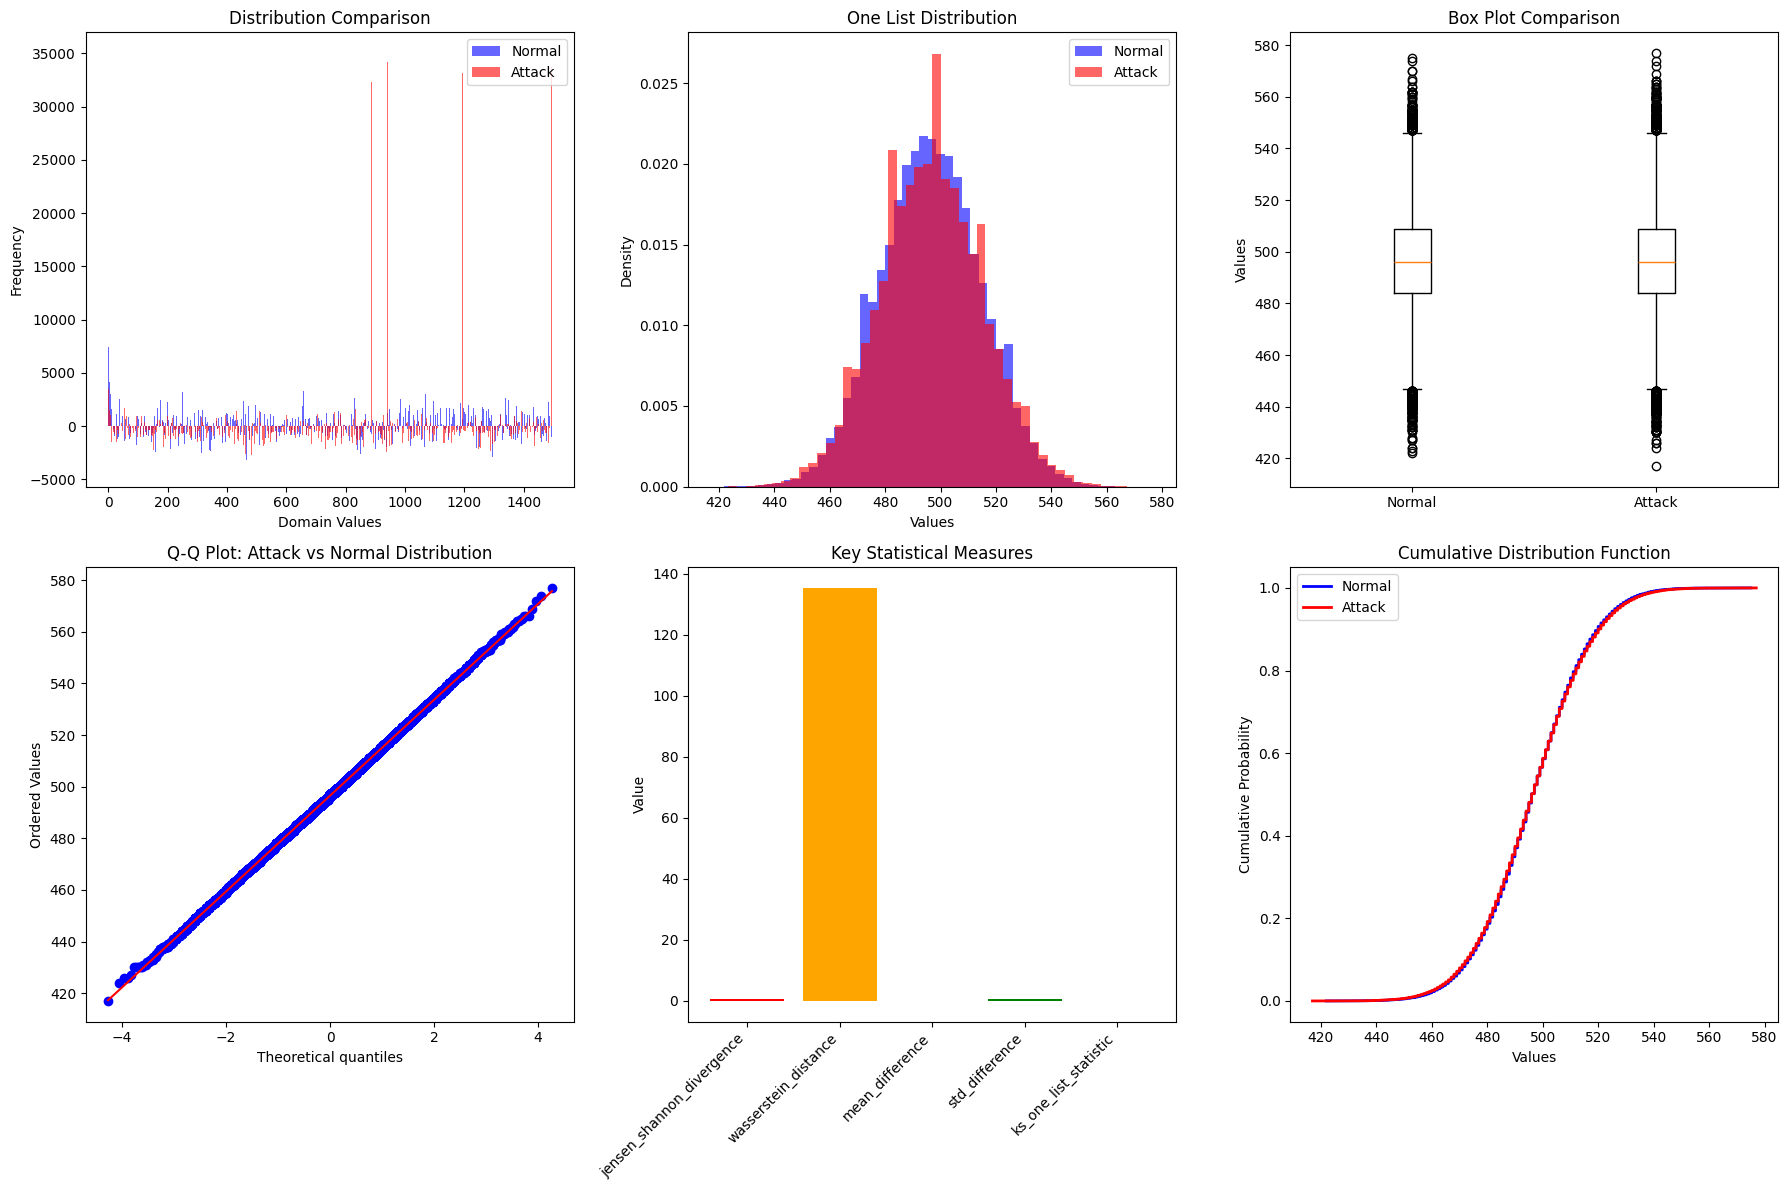

In [ ]:
plot_comparison_analysis(
    ESTIMATE_DIST_Nattack,
    no_attack_ESTIMATE_DIST,
    one_list,
    no_attack_one_list,
    differences
)

### Comparison between attack and benign support vectors

In [ ]:
def simple_hamming_weight_plot(attack_support, benign_support):
    """
    Simple single-plot version for quick comparison
    """
    attack_support = np.array(attack_support)
    benign_support = np.array(benign_support)

    # Calculate Hamming weights
    attack_weights = np.sum(attack_support, axis=1)
    benign_weights = np.sum(benign_support, axis=1)

    # Create simple plot
    plt.figure(figsize=(10, 6))
    plt.hist(attack_weights, bins=50, alpha=0.6, color='red', label='Attack', density=True)
    plt.hist(benign_weights, bins=50, alpha=0.6, color='blue', label='Benign', density=True)
    plt.title('Hamming Weight Distribution Comparison')
    plt.xlabel('Number of 1s per row (Hamming Weight)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add statistics as text
    attack_mean = np.mean(attack_weights)
    benign_mean = np.mean(benign_weights)
    t_stat, t_pvalue = stats.ttest_ind(attack_weights, benign_weights)

    stats_text = f'Attack Mean: {attack_mean:.2f}\nBenign Mean: {benign_mean:.2f}\nDifference: {attack_mean - benign_mean:.2f}\nT-test p-value: {t_pvalue:.2e}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return attack_weights, benign_weights

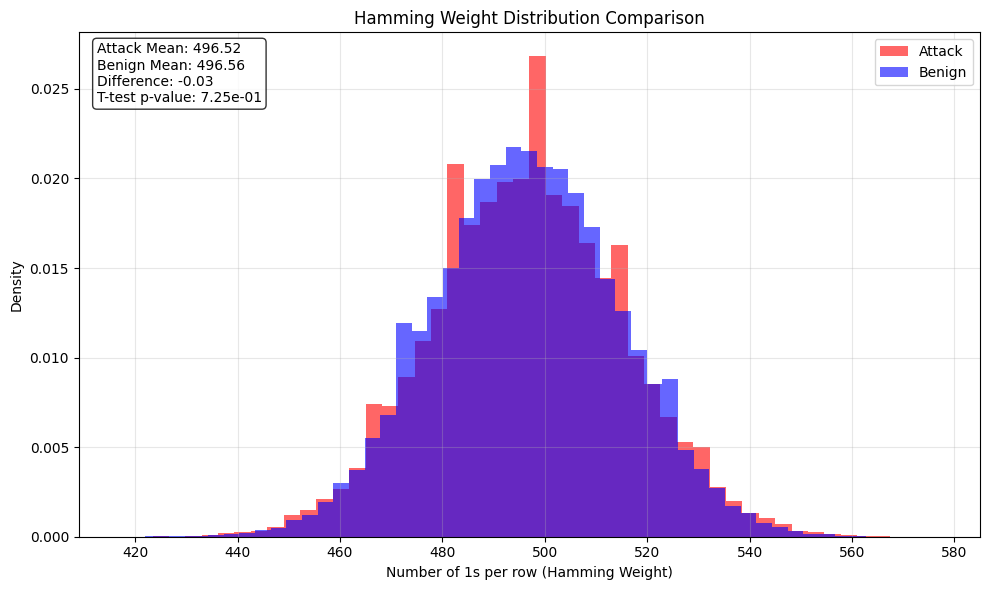

In [ ]:
attack_weights, benign_weights = simple_hamming_weight_plot(support_list, no_attack_support_list)


In [ ]:
from scipy.stats import gaussian_kde

def simple_hamming_weight_curve(attack_support, benign_support):
    """
    Simple curve plot version for quick comparison using KDE
    """
    attack_support = np.array(attack_support)
    benign_support = np.array(benign_support)

    # Calculate Hamming weights
    attack_weights = np.sum(attack_support, axis=1)
    benign_weights = np.sum(benign_support, axis=1)

    # Create simple plot
    plt.figure(figsize=(10, 6))

    # Create smooth curves using Kernel Density Estimation
    # Determine range for x-axis
    min_weight = min(np.min(attack_weights), np.min(benign_weights))
    max_weight = max(np.max(attack_weights), np.max(benign_weights))
    x_range = np.linspace(min_weight, max_weight, 300)

    # Generate KDE curves
    if len(attack_weights) > 1 and np.std(attack_weights) > 0:
        attack_kde = gaussian_kde(attack_weights)
        attack_density = attack_kde(x_range)
    else:
        # Fallback for constant data
        attack_density = np.zeros_like(x_range)
        if len(attack_weights) > 0:
            closest_idx = np.argmin(np.abs(x_range - attack_weights[0]))
            attack_density[closest_idx] = 1.0

    if len(benign_weights) > 1 and np.std(benign_weights) > 0:
        benign_kde = gaussian_kde(benign_weights)
        benign_density = benign_kde(x_range)
    else:
        # Fallback for constant data
        benign_density = np.zeros_like(x_range)
        if len(benign_weights) > 0:
            closest_idx = np.argmin(np.abs(x_range - benign_weights[0]))
            benign_density[closest_idx] = 1.0

    # Plot smooth curves
    plt.plot(x_range, attack_density, color='red', linewidth=2.5, alpha=0.8, label='Attack')
    plt.plot(x_range, benign_density, color='blue', linewidth=2.5, alpha=0.8, label='Benign')

    # Fill areas under curves for better visualization
    plt.fill_between(x_range, attack_density, alpha=0.3, color='red')
    plt.fill_between(x_range, benign_density, alpha=0.3, color='blue')

    plt.title('Hamming Weight Distribution Comparison (Smooth Curves)')
    plt.xlabel('Number of 1s per row (Hamming Weight)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add statistics as text
    attack_mean = np.mean(attack_weights)
    benign_mean = np.mean(benign_weights)
    t_stat, t_pvalue = stats.ttest_ind(attack_weights, benign_weights)

    # Add vertical lines for means
    plt.axvline(attack_mean, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axvline(benign_mean, color='blue', linestyle='--', alpha=0.7, linewidth=1.5)

    stats_text = f'Attack Mean: {attack_mean:.2f}\nBenign Mean: {benign_mean:.2f}\nDifference: {attack_mean - benign_mean:.2f}\nT-test p-value: {t_pvalue:.2e}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

    plt.tight_layout()
    plt.show()

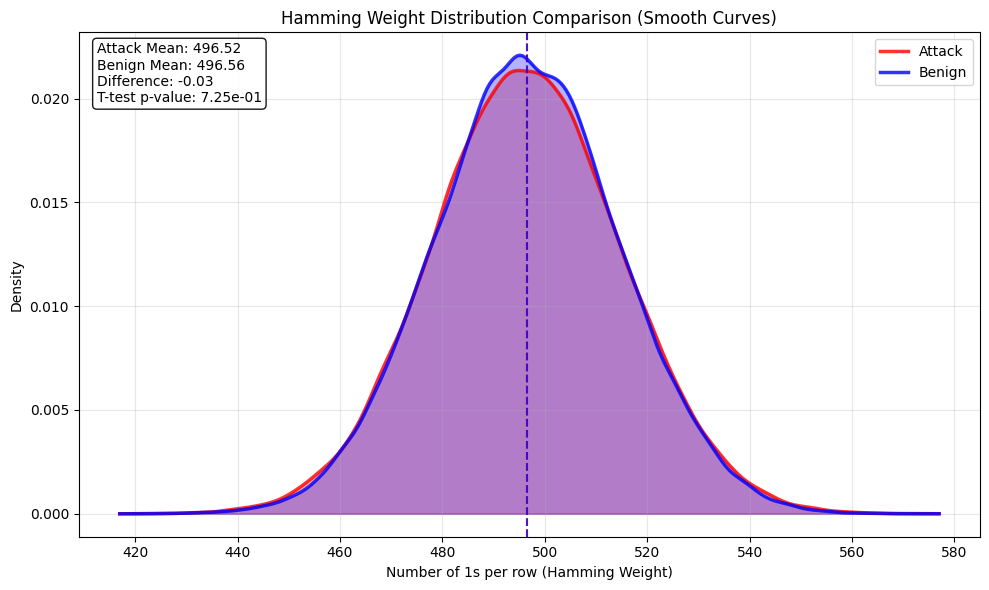

In [ ]:
simple_hamming_weight_curve(support_list, no_attack_support_list)


## Insights
As we can see, the APA is keeping the cumulative frequency consistent to the original, however the density is changing, and it is huge (wasserstein_distance)

In MGA attacks, distribution also shifts, not just the density, so other metrics also capture this difference and variation is also high (mean and std difference).

# GAN